In [1]:
import os
import sys
import re
import h5py
import json
import click
import warnings

import numpy as np
import pandas as pd
import sqlite3

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers


import skimage
from skimage.io import imread, imshow, imsave
import skimage.transform
import skimage.color

import matplotlib.pyplot as plt
% matplotlib inline

conn = sqlite3.connect('../data/info.sqlite')
cursor = conn.cursor()
sql = "select * from info"

df = pd.read_sql(sql, conn)
N = len(df)
X = np.zeros([N, 224, 224, 3])
y = np.zeros([N, ])

dic_main = {}
collection = ['al', 'ci', 'cu', 'ti', 'cs', 'as', 'cc', 'co',
              'hs', 'lz', 'mg', 'ni', 'pl', 'rf', 'sc', 'sp',
              'ss', 'ts', 'un']
for i in range(0, 19):
    dic_main[collection[i]]=i
    
ids=[]
paths_ori=[]
paths_scaled=[]

collection_test = ['al','ci','cu','ti','cs']

j=0
for i in range(0, N):
    path_ori = df.loc[i]['ori_image'].encode('utf-8').decode('utf-8')
    paths_ori.append(path_ori)
    path_scaled = df.loc[i]['scaled_image'].encode('utf-8').decode('utf-8')
    paths_scaled.append(path_scaled)
    main = df.loc[i]['main'].encode('utf-8').decode('utf-8')
    y[i] = dic_main[main]
    if df.loc[i]['main'] in collection_test:
        ids.append(i)

fc1=np.load('../data/preprocessed/asm-vgg16-fc1.npy')
fc2=np.load('../data/preprocessed/asm-vgg16-fc2.npy')

N=len(ids)

fc1_raw=np.array([fc1[i] for i in ids]).reshape([N, 4096])
fc2_raw=np.array([fc2[i] for i in ids]).reshape([N, 4096])
y_raw=[y[i] for i in ids]
paths_ori_raw=[paths_ori[i] for i in ids]
paths_scaled_raw=[paths_scaled[i] for i in ids]
class_ids=[dic_main[df.loc[i]['main']] for i in ids]

Using TensorFlow backend.


In [34]:
import keras.backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras import optimizers

def linear_softmax_classifier(n_classes=5, input_dim=4096):
    
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(32, input_shape=(input_dim,), activation='relu', name='mid')(input_layer)
    output_layer = Dense(n_classes, activation='softmax', name='out')(output_layer)

    return Model(inputs=input_layer, outputs=output_layer)


In [150]:
t_fc1

array([4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 1, 0, 4, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       2, 2, 2, 4, 4, 4, 2, 4, 4, 1, 4, 4, 1, 0, 4, 2, 4, 2, 4, 4, 4, 4, 4,
       0, 4, 3, 4, 3, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 1, 4, 2, 4, 3, 4, 4,
       4, 2, 4, 4, 4, 4, 2, 1, 4, 4, 0, 4, 4, 3, 2, 2, 4, 4, 1, 0, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 4, 4, 4, 2, 1, 4, 1, 0, 1, 4, 1, 2, 4, 0, 4, 4, 4,
       4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 2, 2, 2, 4, 4, 4, 3, 0, 4,
       4, 2, 0, 2, 4, 4, 4, 1, 2, 4, 4, 4, 2, 4, 3, 1, 0, 0, 4, 4, 4, 4, 4,
       1, 4, 4, 1, 3, 4, 4, 3, 4, 2, 2, 3, 4, 3, 0, 4, 4, 0, 4, 2, 4, 4, 0,
       4, 2, 2, 4, 4, 2, 2, 3, 4, 2, 3, 0, 2, 4, 4, 4, 2, 2, 2, 4, 4, 4, 1,
       2, 4, 4, 4, 0, 4, 0, 4, 2, 2, 3, 4, 4, 2, 1, 4, 4, 0, 0, 3, 0, 3, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 0, 1, 2, 2, 0, 2, 2,
       3, 3, 2, 4, 0, 4, 4, 4, 4, 4, 0, 2, 4, 1, 3, 2, 4, 0, 1, 4, 1, 4, 4,
       2, 4, 2, 0, 0, 4, 4, 0, 1, 4, 1, 0, 3, 0, 1, 1, 1, 4, 4, 0, 2, 4, 4,
       4, 2,

In [48]:
lm_fc1 = linear_softmax_classifier(n_classes=5)
lm_fc1.summary()
opt = optimizers.Adam(lr=0.00001)
lm_fc1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(np.array(class_ids))
# shuffle training data to get shuffled validation data
np.random.seed(7)
initial_shuf = np.random.permutation(N)
X_fc1_train = fc1_raw[initial_shuf][:2499,:]
label_train = target[initial_shuf][:2499,:]
svm_label_train = np.array(class_ids)[initial_shuf][:2499,]
X_fc1_test = fc1_raw[initial_shuf][2499:,:]
t_fc1 = np.array(class_ids)[initial_shuf][2499:,]
hist = lm_fc1.fit(X_fc1_train, label_train, validation_split=0.2, epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
mid (Dense)                  (None, 32)                131104    
_________________________________________________________________
out (Dense)                  (None, 5)                 165       
Total params: 131,269
Trainable params: 131,269
Non-trainable params: 0
_________________________________________________________________
Train on 1999 samples, validate on 500 samples
Epoch 1/200
1999/1999 [==============================] - 0s - loss: 3.5418 - acc: 0.2181 - val_loss: 2.8759 - val_acc: 0.3160

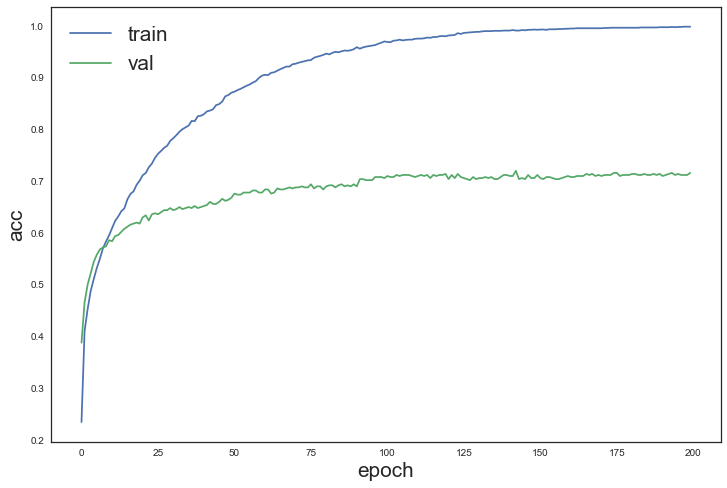

In [36]:
metric = 'acc' # 'loss' | 'acc'
plt.figure(figsize=(12,8))
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch', fontsize='xx-large')
plt.ylabel(metric, fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.savefig('classifier/acc.png')

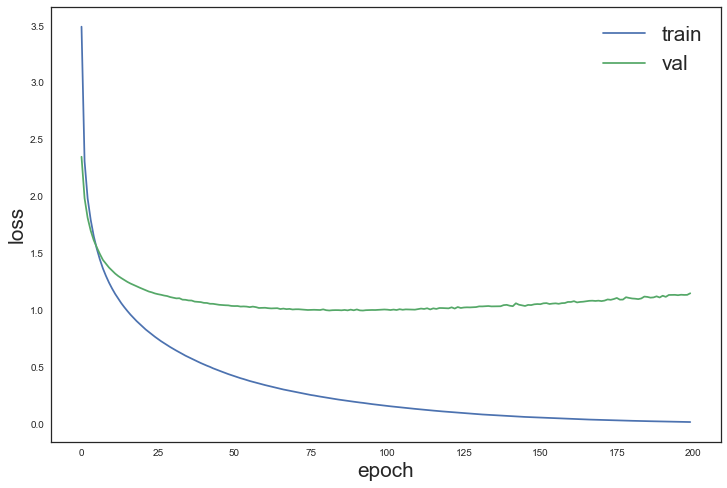

In [37]:
metric = 'loss' # 'loss' | 'acc'
plt.figure(figsize=(12,8))
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch', fontsize='xx-large')
plt.ylabel(metric, fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.savefig('classifier/loss.png')

# Make confusion heatmap

#### cmap possible values are:

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='white')

def evaluate_confusion_matrix(model, testdata, y_test):

    p = model.predict(testdata)
    p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
    pred = np.argmax(p, axis=-1)
    plt.figure(figsize=(12,12))

    conf_raw = confusion_matrix(y_test, pred)
    conf=np.zeros([conf_raw.shape[0], conf_raw.shape[1]])
    for i in range(conf_raw.shape[0]):
        summ=0
        for j in range(conf_raw.shape[1]):
            summ=summ+conf_raw[i][j]
        for j in range(conf_raw.shape[1]):
            conf[i][j]=conf_raw[i][j]/summ

    sns.heatmap(
        conf, annot=True, square=True, 
        cmap='Blues',
        mask=(conf == 0), linewidths=1, linecolor='white',
        xticklabels=sorted(set(collection_test)),
        yticklabels=sorted(set(collection_test))
    )

    plt.xlabel('predicted class', fontsize='xx-large')
    plt.ylabel('true class', fontsize='xx-large')

In [39]:
labels_test=['Al', 'Ci', 'Cu', 'Ti', 'Cs']

['Al', 'Ci', 'Cs', 'Cu', 'Ti']

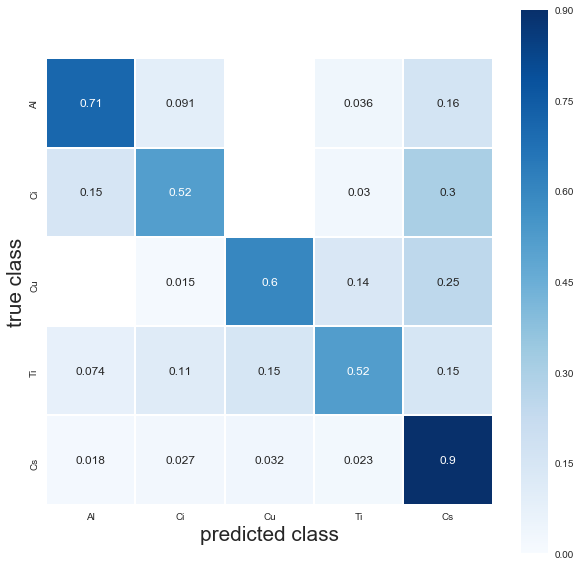

In [157]:
p=lm_fc1.predict(X_fc1_test)
p = np.squeeze(p)
pred = np.argmax(p, axis=-1)
conf_raw = confusion_matrix(t_fc1, pred)
conf =np.zeros([conf_raw.shape[0], conf_raw.shape[1]])
for i in range(conf_raw.shape[0]):
    summ=0
    for j in range(conf_raw.shape[1]):
        summ=summ+conf_raw[i][j]
    for j in range(conf_raw.shape[1]):
        conf[i][j]=conf_raw[i][j]*1.0/summ
plt.figure(figsize=(10,10))
sns.heatmap(
    conf, annot=True, square=True, 
    cmap='Blues',
    mask=(conf == 0), linewidths=1, linecolor='white',
    xticklabels=labels_test,
    yticklabels=labels_test,
)

plt.xlabel('predicted class', fontsize='xx-large')
plt.ylabel('true class', fontsize='xx-large')
plt.savefig('classifier/heatmap.png')

# Take the middle output of fc1 fitting 

In [28]:
from keras.models import Model
 
model = lm_fc1  # create the original model
 
layer_name = 'mid'
intermediate_layer_model = Model(input=model.input,
                                output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(fc1_raw)

/mnt/data/sw/python/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{m..., inputs=/input_4)`
  import sys


In [32]:
x_pca=np.load('../map/x_pca.npy')
x_tsne=np.load('../map/x_tsne.npy')

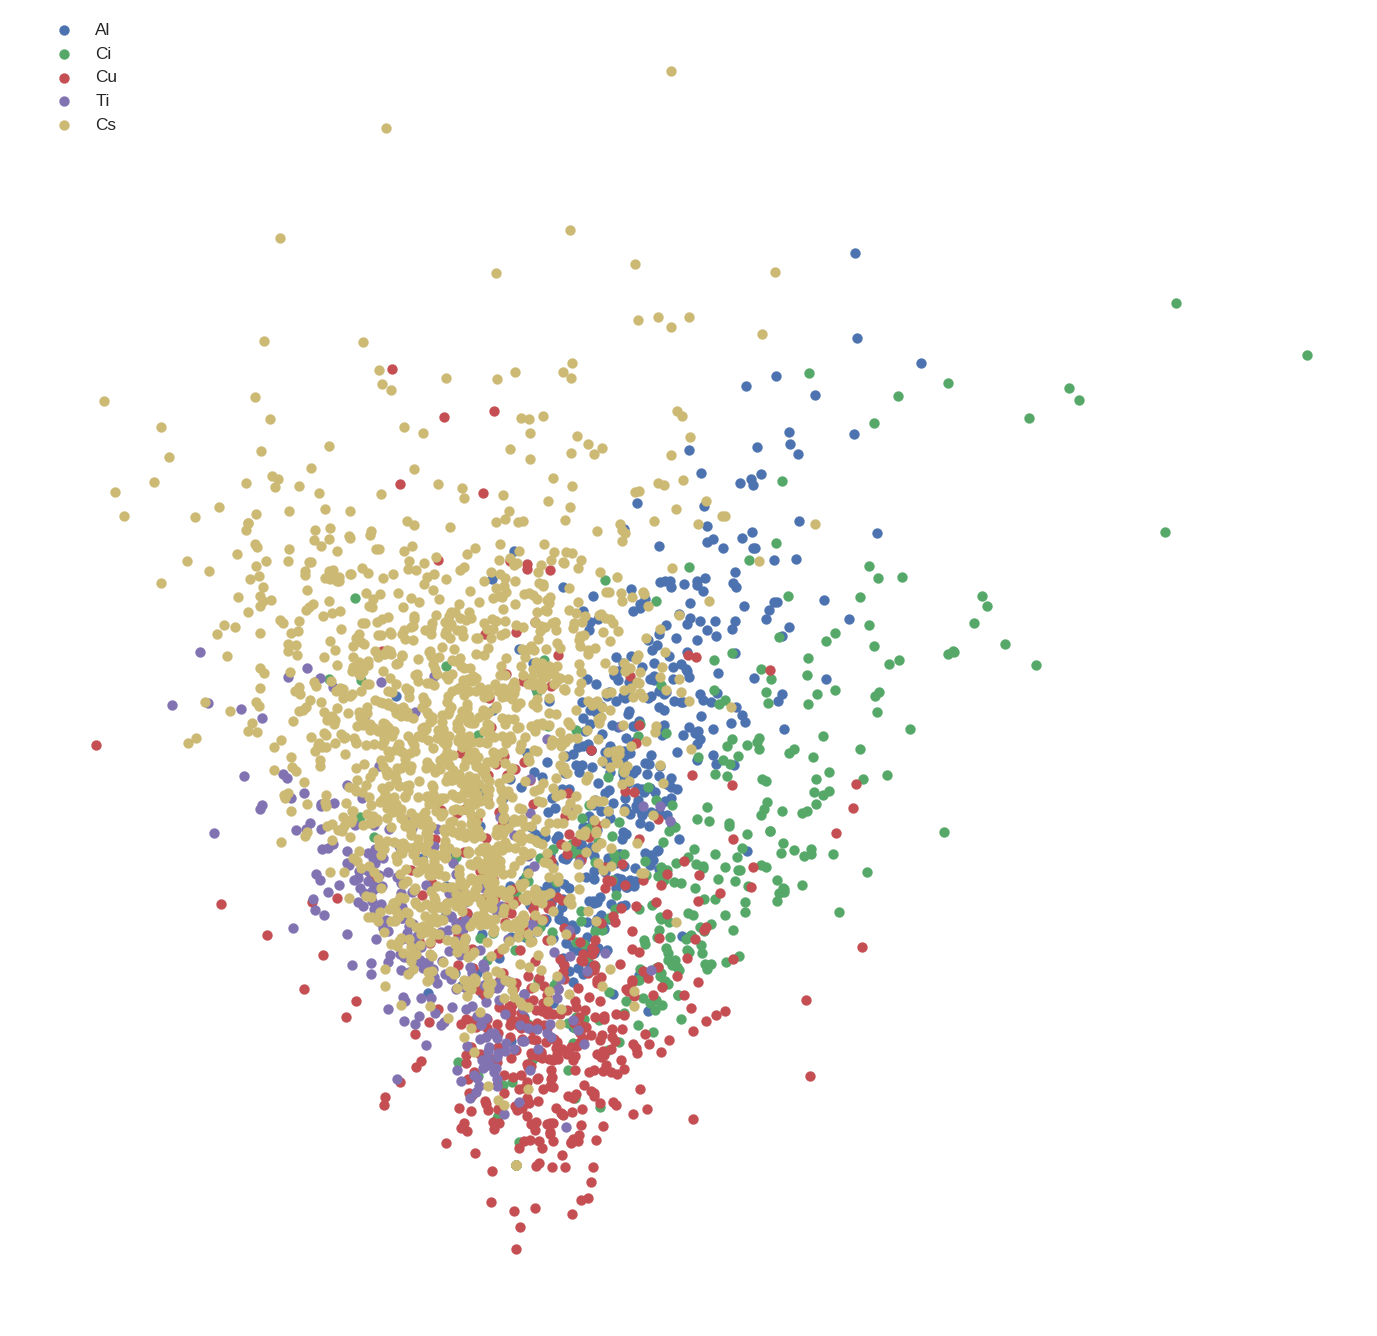

In [33]:
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=2)

# x_pca = pca_model.fit_transform(intermediate_output)
plt.figure(figsize=(24,24))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_pca[0:418,0], x_pca[0:418,1], s=100, label='Al', cmap=cm)
plt.scatter(x_pca[419:718,0], x_pca[419:718,1], s=100, label='Ci', cmap=cm)
plt.scatter(x_pca[2190:2636,0], x_pca[2190:2636,1], s=100, label='Cu', cmap=cm)
plt.scatter(x_pca[2637:2898,0], x_pca[2637:2898,1], s=100, label='Ti', cmap=cm)
plt.scatter(x_pca[719:2189,0], x_pca[719:2189,1], s=100, label='Cs', cmap=cm)

plt.axis('off')

legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')

plt.savefig('../map/pca.png')

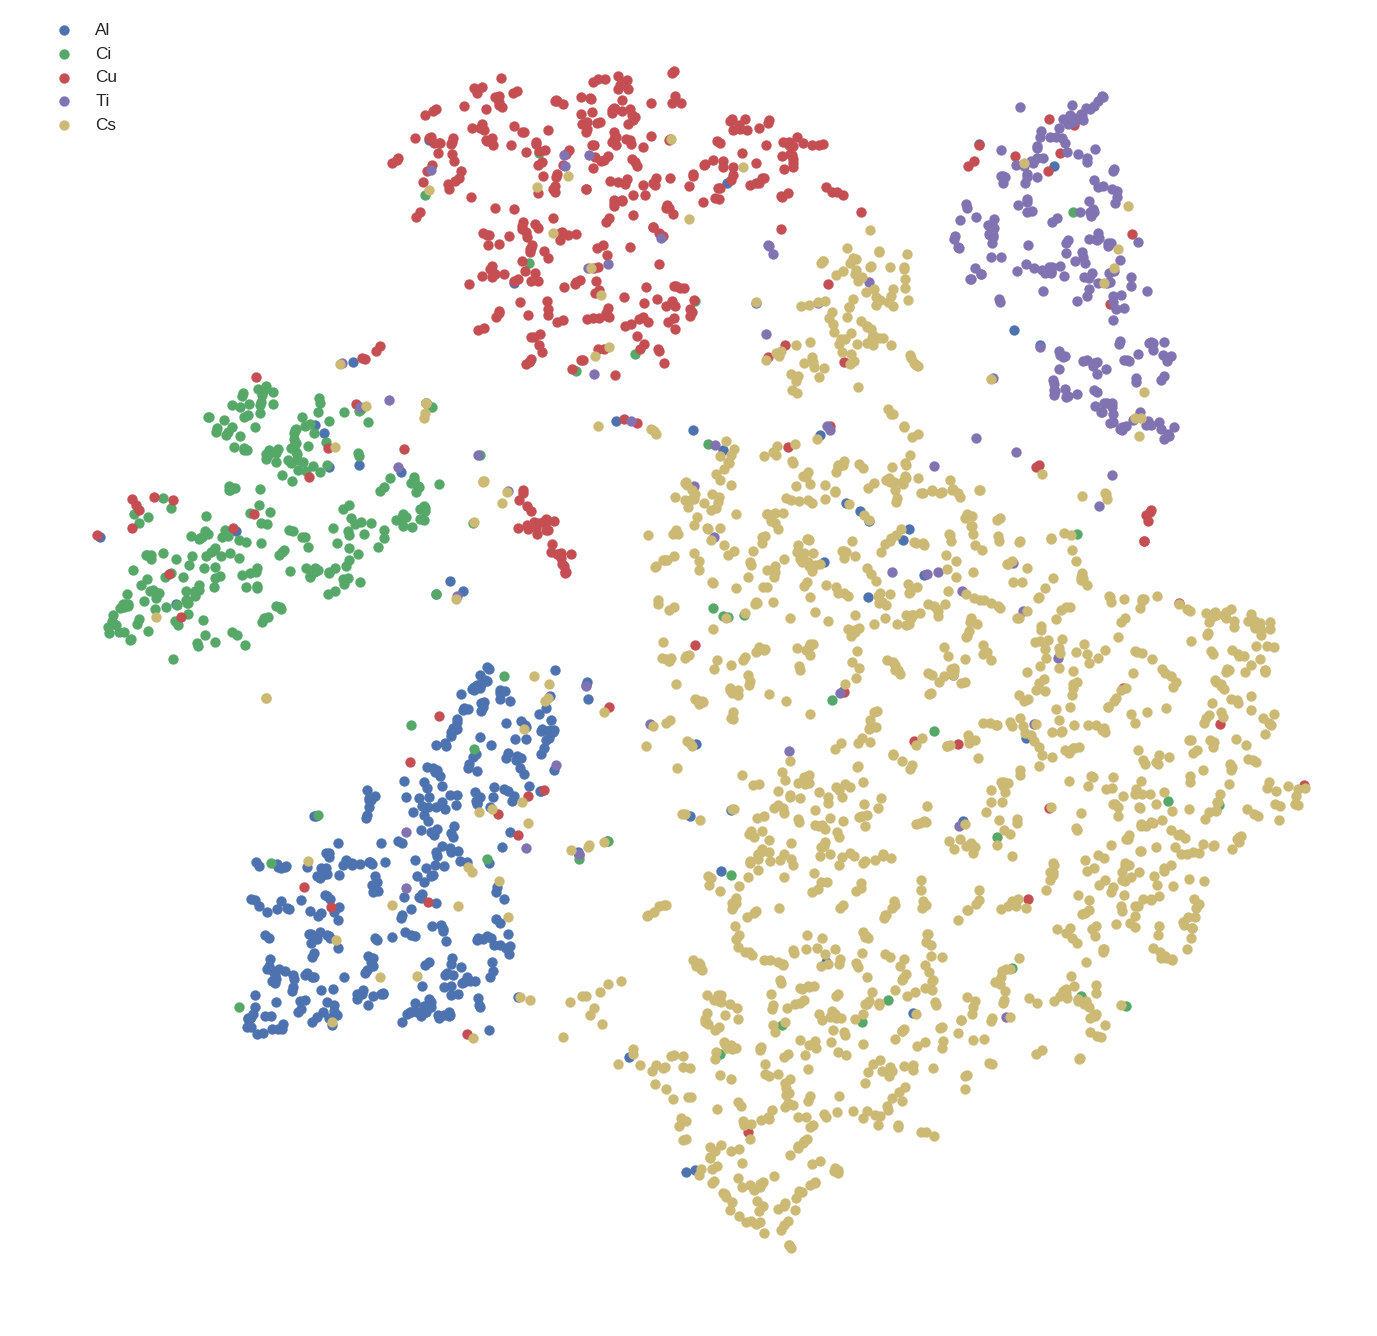

In [34]:
# from ntsne import ntsne
# from sklearn.decomposition import PCA
# pca_model=PCA(n_components=20)
# x_pca=pca_model.fit_transform(intermediate_output)
# x_tsne=ntsne.tsne(x_pca)
plt.figure(figsize=(24,24))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[0:418,0], x_tsne[0:418,1], s=100, label='Al', cmap=cm)
plt.scatter(x_tsne[419:718,0], x_tsne[419:718,1], s=100, label='Ci', cmap=cm)
plt.scatter(x_tsne[2190:2636,0], x_tsne[2190:2636,1], s=100, label='Cu', cmap=cm)
plt.scatter(x_tsne[2637:2898,0], x_tsne[2637:2898,1], s=100, label='Ti', cmap=cm)
plt.scatter(x_tsne[719:2189,0], x_tsne[719:2189,1], s=100, label='Cs', cmap=cm)
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne.png')

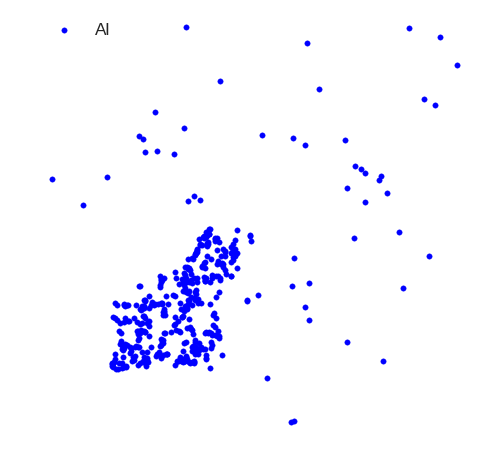

In [35]:
plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[0:418,0], x_tsne[0:418,1], s=30, label='Al', c='blue')
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne-al.png')

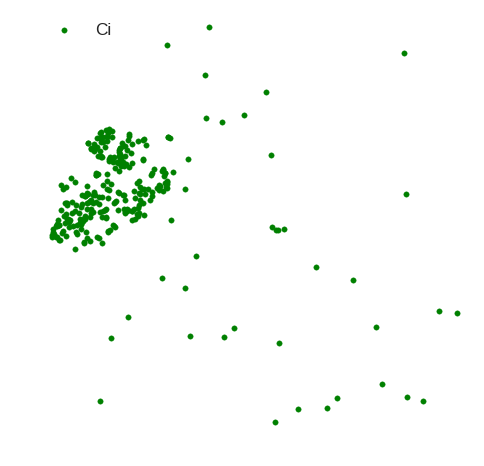

In [36]:
plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[419:718,0], x_tsne[419:718,1], s=30, label='Ci', c='green')
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne-ci.png')

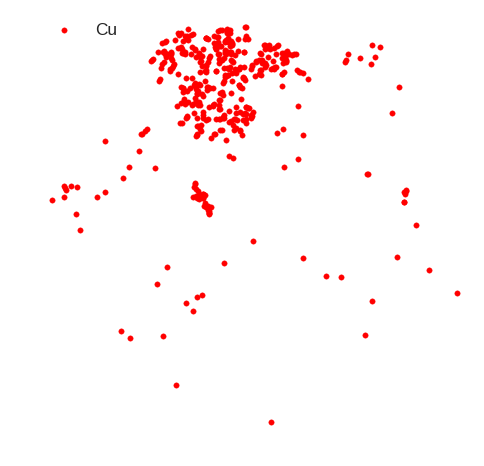

In [37]:
plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[2190:2636,0], x_tsne[2190:2636,1], s=30, label='Cu', c='red')
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne-cu.png')

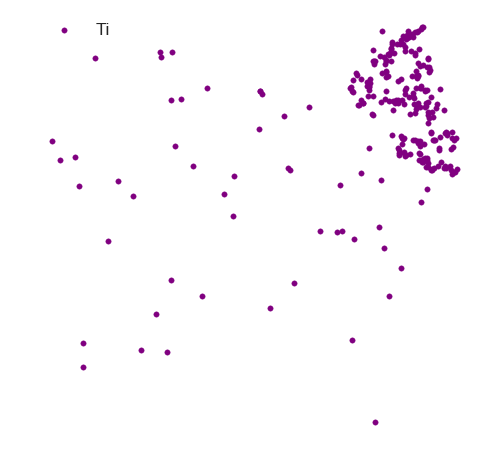

In [38]:
plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu')  
plt.scatter(x_tsne[2637:2898,0], x_tsne[2637:2898,1], s=30, label='Ti', c='purple')
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne-ti.png')

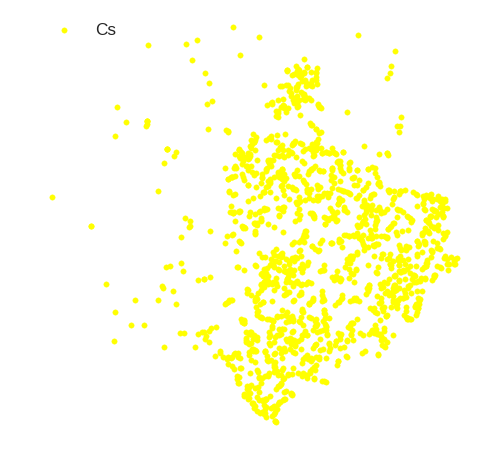

In [39]:
plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[719:2189,0], x_tsne[719:2189,1], s=30, label='Cs', c='yellow')
legend = plt.legend(loc='upper left', shadow=True, fontsize='xx-large')
plt.axis('off')

plt.savefig('../map/ntsne-cs.png')

In [96]:
np.save('../map/x_pca.npy', x_pca)
np.save('../map/x_tsne.npy', x_tsne)

# Save the position of graphs for the next mapping

In [ ]:
def image_montage(X, images, bordercolors, mapsize=8192, thumbsize=256, bordersize=4, verbose=False):
    """ make image maps in an embedding space """

    halfthumbsize = int((thumbsize + 2*bordersize)/2)
    map_shape = np.array([mapsize,mapsize,3])
    imagemap = np.ones(map_shape)

    # rescale max distance from origin to 1
    scale = np.max(np.abs(X[:,0:2]))

    # choose some random images to draw
    # sel = np.random.choice(range(keys.size), replace=False, size=2000)

    for ids, image in enumerate(images):

        # get image position
        pos = X[ids][:2]
    
        # load image
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            im = images[ids,:,:,:]
    
        # make thumbnail
        thumbnail = skimage.transform.resize(im, (thumbsize,thumbsize), order=1)

        # convert to float+color -- float enables use of marker value (-1)
        thumbnail = skimage.img_as_float(thumbnail)

        # add a colored border
        bordercolor = bordercolors[ids]
        thumbnail = np.lib.pad(thumbnail, ((bordersize,bordersize), (bordersize,bordersize), (0,0)),
                               'constant', constant_values=(-1,-1))
        thumbnail[thumbnail[:,:,0] == -1] = bordercolor

        # map position to image coordinates with buffer region
        # x,y = np.round(pos/scale * ((mapsize-(thumbsize+3+bordersize))/2) + (mapsize/2)).astype(int)
        x,y = np.round(pos/scale * ((mapsize-(thumbsize+10+bordersize))/2) + (mapsize/2)).astype(int)
        x = mapsize-x # image convention -- match scatter plot
        # place thumbnail into image map
        if verbose:
            print(thumbnail.shape)
            print(halfthumbsize*2)
            print('({},{})'.format(x,y))
        imagemap[x-(halfthumbsize):x+(halfthumbsize),y-(halfthumbsize):y+(halfthumbsize),:] = thumbnail

    return imagemap

In [ ]:
import warnings
warnings.filterwarnings("ignore")
colors=[np.array([1, 1, 1]) for image in fc1_raw]
imagemap = image_montage(x_tsne, X_raw, bordercolors=colors, mapsize=8192, thumbsize=256, bordersize=1)
plt.imshow(imagemap)


In [ ]:
mont_max=np.max(imagemap)
for i in range(0, 8192):
    for j in range(0, 8192):
        for k in range(0, 3):
            imagemap[i, j, k]=int(imagemap[i, j, k]/mont_max*255.0)
skimage.io.imsave('tsne-map.png', imagemap)

In [70]:
def accuracy(pred, act):
    n = len(pred)
    m = 0
    for i in range(0, n):
        if pred[i] == act[i]:
            m = m + 1
    return m*1.0/n

In [164]:
# Linear model:

from sklearn.svm import SVC
model = SVC(C=1, kernel='linear', verbose=True, cache_size=1000)

%time model.fit(X_fc1_train, svm_label_train)

score = model.score(X_fc1_train, svm_label_train)
print('training acc: {}'.format(score))

y_pred_linear=model.predict(X_fc1_test)
print accuracy(y_pred_linear, t_fc1)
# np.save('predict_linear.npy', y_pred)

[LibSVM]CPU times: user 27.2 s, sys: 314 ms, total: 27.5 s
Wall time: 28.3 s
training acc: 1.0
0.7625


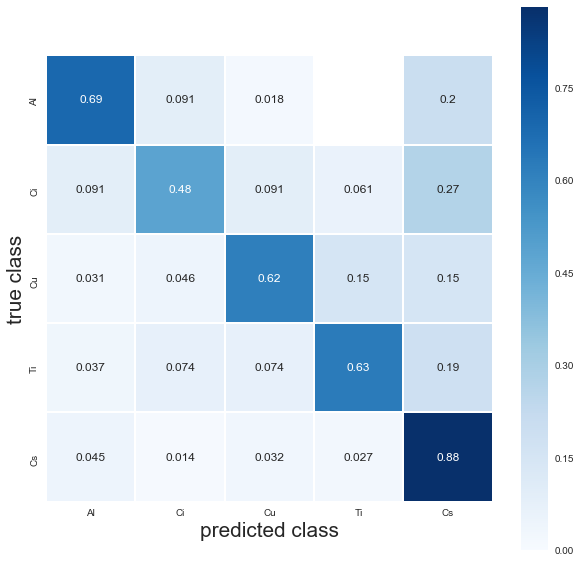

In [165]:
p=lm_fc1.predict(X_fc1_test)
p = np.squeeze(p)
pred = np.argmax(p, axis=-1)
conf_raw = confusion_matrix(t_fc1, y_pred_linear)
conf =np.zeros([conf_raw.shape[0], conf_raw.shape[1]])
for i in range(conf_raw.shape[0]):
    summ=0
    for j in range(conf_raw.shape[1]):
        summ=summ+conf_raw[i][j]
    for j in range(conf_raw.shape[1]):
        conf[i][j]=conf_raw[i][j]*1.0/summ
plt.figure(figsize=(10,10))
sns.heatmap(
    conf, annot=True, square=True, 
    cmap='Blues',
    mask=(conf == 0), linewidths=1, linecolor='white',
    xticklabels=labels_test,
    yticklabels=labels_test,
)

plt.xlabel('predicted class', fontsize='xx-large')
plt.ylabel('true class', fontsize='xx-large')
plt.savefig('classifier/heatmap_linear.png')

In [166]:
# Poly(degree=2) model:

from sklearn.svm import SVC
model = SVC(C=1, kernel='poly', degree=2, verbose=True, cache_size=1000)
%time model.fit(X_fc1_train, svm_label_train)

score = model.score(X_fc1_train, svm_label_train)
print('training acc: {}'.format(score))

y_pred_poly2=model.predict(X_fc1_test)
print accuracy(y_pred_poly2, t_fc1)
# np.save('predict_linear.npy', y_pred)

[LibSVM]CPU times: user 32.2 s, sys: 461 ms, total: 32.6 s
Wall time: 33.5 s
training acc: 0.999199679872
0.78


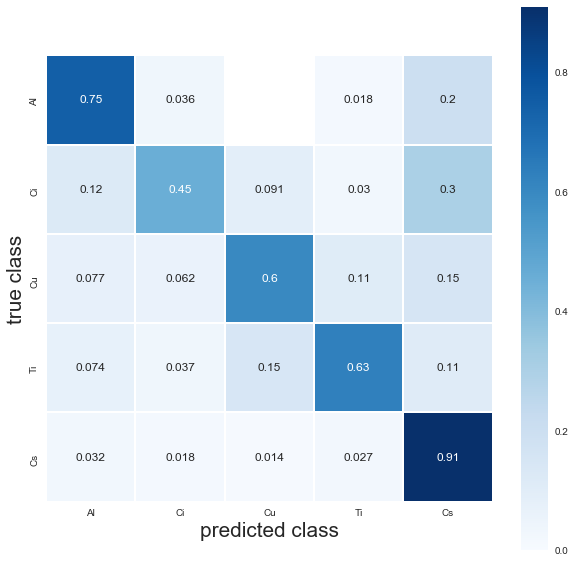

In [167]:
p=lm_fc1.predict(X_fc1_test)
p = np.squeeze(p)
pred = np.argmax(p, axis=-1)
conf_raw = confusion_matrix(t_fc1, y_pred_poly2)
conf =np.zeros([conf_raw.shape[0], conf_raw.shape[1]])
for i in range(conf_raw.shape[0]):
    summ=0
    for j in range(conf_raw.shape[1]):
        summ=summ+conf_raw[i][j]
    for j in range(conf_raw.shape[1]):
        conf[i][j]=conf_raw[i][j]*1.0/summ
plt.figure(figsize=(10,10))
sns.heatmap(
    conf, annot=True, square=True, 
    cmap='Blues',
    mask=(conf == 0), linewidths=1, linecolor='white',
    xticklabels=labels_test,
    yticklabels=labels_test,
)

plt.xlabel('predicted class', fontsize='xx-large')
plt.ylabel('true class', fontsize='xx-large')
plt.savefig('classifier/heatmap_poly2.png')

In [168]:
# Poly(degree=3) model:

from sklearn.svm import SVC
model = SVC(C=1, kernel='poly', degree=3, verbose=True, cache_size=1000)
%time model.fit(X_fc1_train, svm_label_train)

score = model.score(X_fc1_train, svm_label_train)
print('training acc: {}'.format(score))

y_pred_poly3=model.predict(X_fc1_test)
print accuracy(y_pred_poly3, t_fc1)
# np.save('predict_linear.npy', y_pred)

[LibSVM]CPU times: user 33.9 s, sys: 416 ms, total: 34.3 s
Wall time: 35 s
training acc: 1.0
0.77


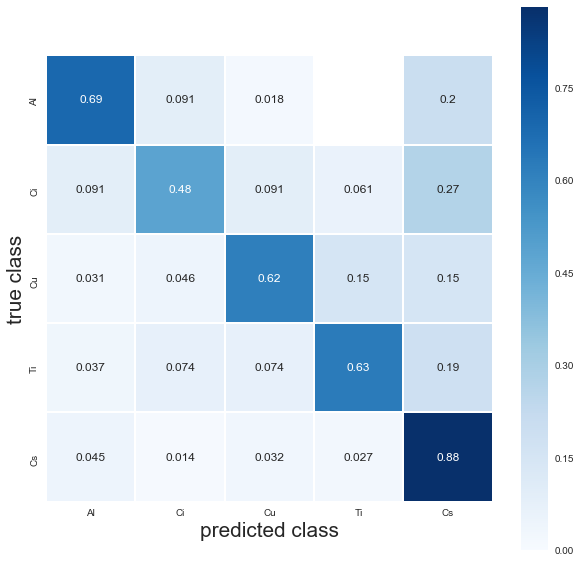

In [169]:
p=lm_fc1.predict(X_fc1_test)
p = np.squeeze(p)
pred = np.argmax(p, axis=-1)
conf_raw = confusion_matrix(t_fc1, y_pred_linear)
conf =np.zeros([conf_raw.shape[0], conf_raw.shape[1]])
for i in range(conf_raw.shape[0]):
    summ=0
    for j in range(conf_raw.shape[1]):
        summ=summ+conf_raw[i][j]
    for j in range(conf_raw.shape[1]):
        conf[i][j]=conf_raw[i][j]*1.0/summ
plt.figure(figsize=(10,10))
sns.heatmap(
    conf, annot=True, square=True, 
    cmap='Blues',
    mask=(conf == 0), linewidths=1, linecolor='white',
    xticklabels=labels_test,
    yticklabels=labels_test,
)

plt.xlabel('predicted class', fontsize='xx-large')
plt.ylabel('true class', fontsize='xx-large')
plt.savefig('classifier/heatmap_poly3.png')

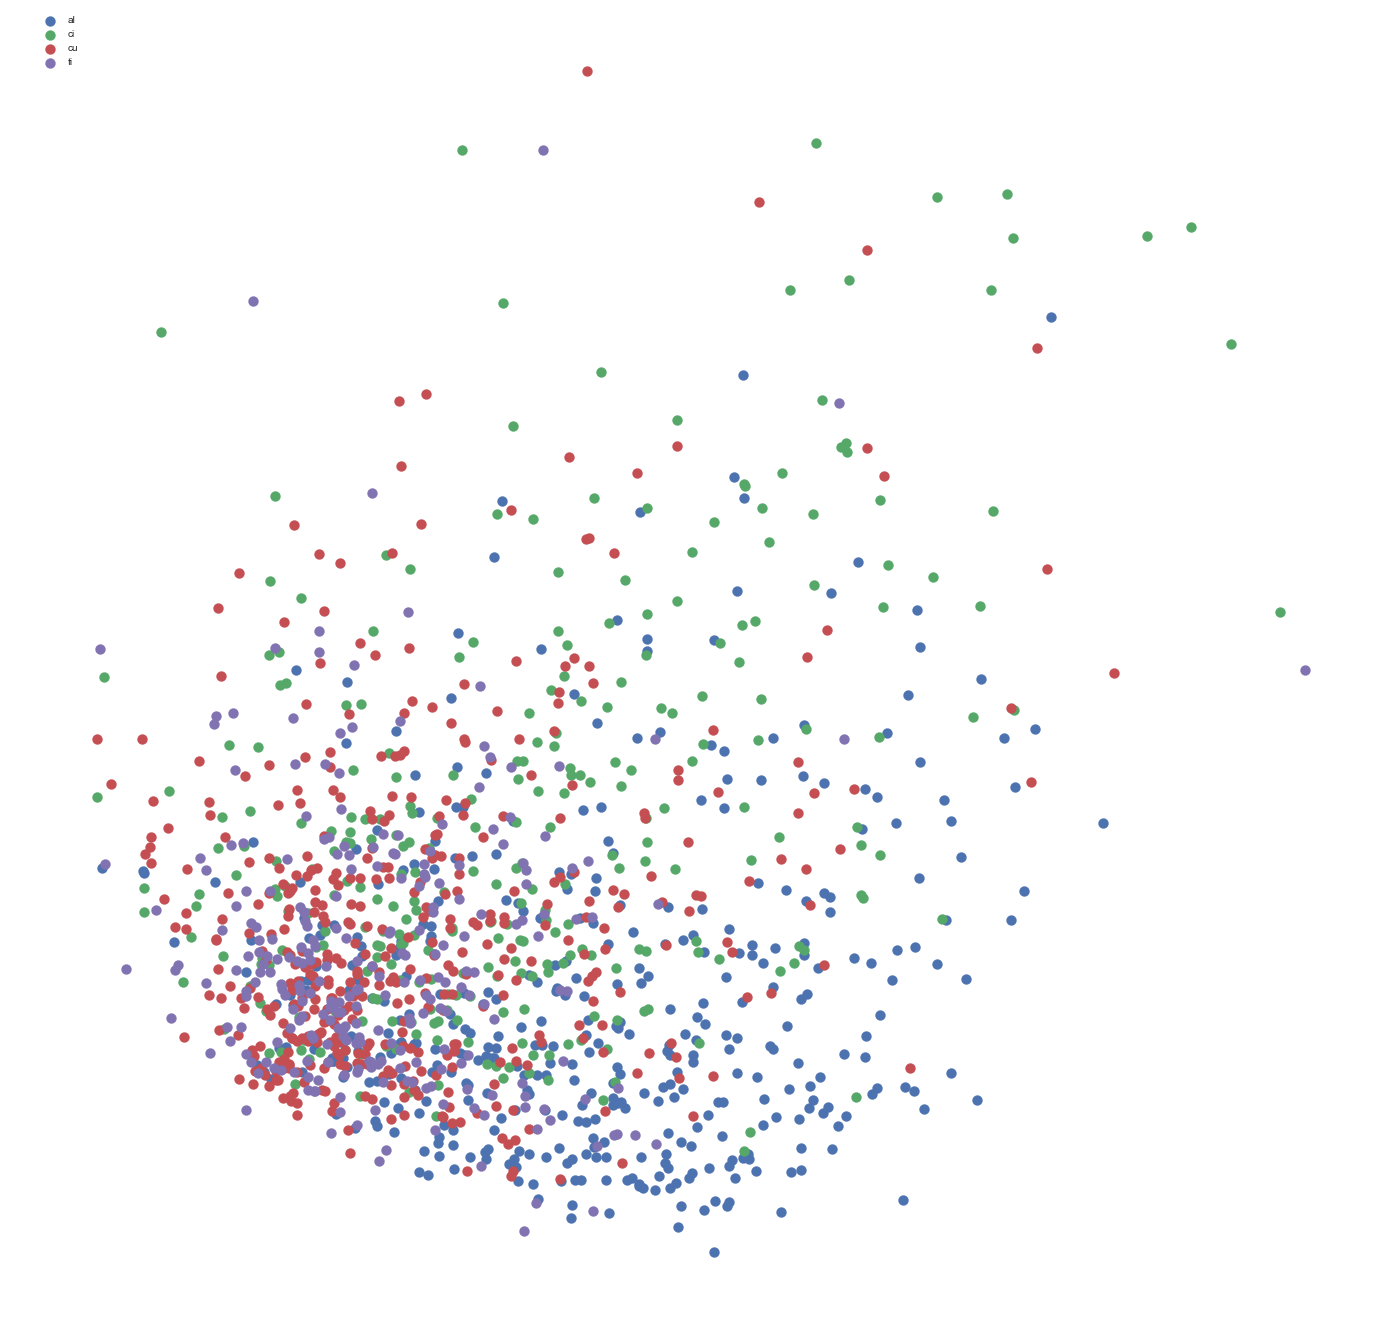

In [170]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)

x_pca = pca_model.fit_transform(fc1_raw)
plt.figure(figsize=(24,24))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_pca[0:418,0], x_pca[0:418,1], s=100, label='al', cmap=cm)
plt.scatter(x_pca[419:718,0], x_pca[419:718,1], s=100, label='ci', cmap=cm)
plt.scatter(x_pca[2190:2636,0], x_pca[2190:2636,1], s=100, label='cu', cmap=cm)
plt.scatter(x_pca[2637:2898,0], x_pca[2637:2898,1], s=100, label='ti', cmap=cm)
# plt.scatter(x_pca[719:2189,0], x_pca[719:2189,1], s=100, label='cs', cmap=cm)

plt.axis('off')
plt.legend(loc='upper left')
plt.savefig('../map/pca_raw.png')

In [171]:
from ntsne import ntsne
from sklearn.decomposition import PCA
pca_model=PCA(n_components=20)
x_pca=pca_model.fit_transform(fc1_raw)
x_tsne=ntsne.tsne(x_pca)
plt.figure(figsize=(24,24))
cm = plt.cm.get_cmap('RdYlBu') 
plt.scatter(x_tsne[0:418,0], x_tsne[0:418,1], s=100, label='al', cmap=cm)
plt.scatter(x_tsne[419:718,0], x_tsne[419:718,1], s=100, label='ci', cmap=cm)
plt.scatter(x_tsne[2190:2636,0], x_tsne[2190:2636,1], s=100, label='cu', cmap=cm)
plt.scatter(x_tsne[2637:2898,0], x_tsne[2637:2898,1], s=100, label='ti', cmap=cm)
# plt.scatter(x_tsne[719:2189,0], x_tsne[719:2189,1], s=100, label='cs', cmap=cm)
plt.legend(loc='upper left')
plt.axis('off')

plt.savefig('../map/ntsne_raw.png')

ImportError: No module named ntsne